#### Calculate a reasonable LST value for every surface classification in ERA5 Dataset



In [24]:
#
import xarray as xr
import matplotlib.pyplot as plt

import sys

sys.path.append("../../")

from src.processing import windsat_datacube

# Files
ws_path = "../../data/raw/daily_windsat/"
telsem_path = "../../data/processed/WinsatEmiss/"


The windsat datacube has ERA5 surtep in it. we get the flags for surface class from telsem atlas

In [27]:
telsem_ds = xr.open_mfdataset(
    paths = "../../data/processed/WinsatEmiss/*.nc",
    engine="netcdf4",
    concat_dim="month",
    combine="nested"
)
telsem_ds = telsem_ds.roll(
    {
        "longitude_grid": 4 * 180
    }
)

sclass= telsem_ds.Surface_class1.sel(month = 1)


---

We are interested in the surface class 1, from 1 to 5 we have the flags for vebetation (from forest to desert respectivelly) that we will assign to a smooth, 5-seps range of vegetation cover, from fully covered to bare soil.




In [69]:
# Create the lat-lon mask for the surface classes
masks =[]
for i in range(1,6,1):
    ncol = (i-1) // 3
    nrow = (i-1) % 3
    mask = sclass.where(sclass == i)
    masks.append(mask)


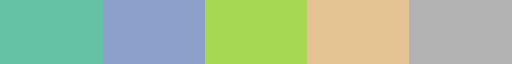

In [65]:
import matplotlib as mpl
cmap = mpl.colormaps.get_cmap("Set2").resampled(5)
cmap

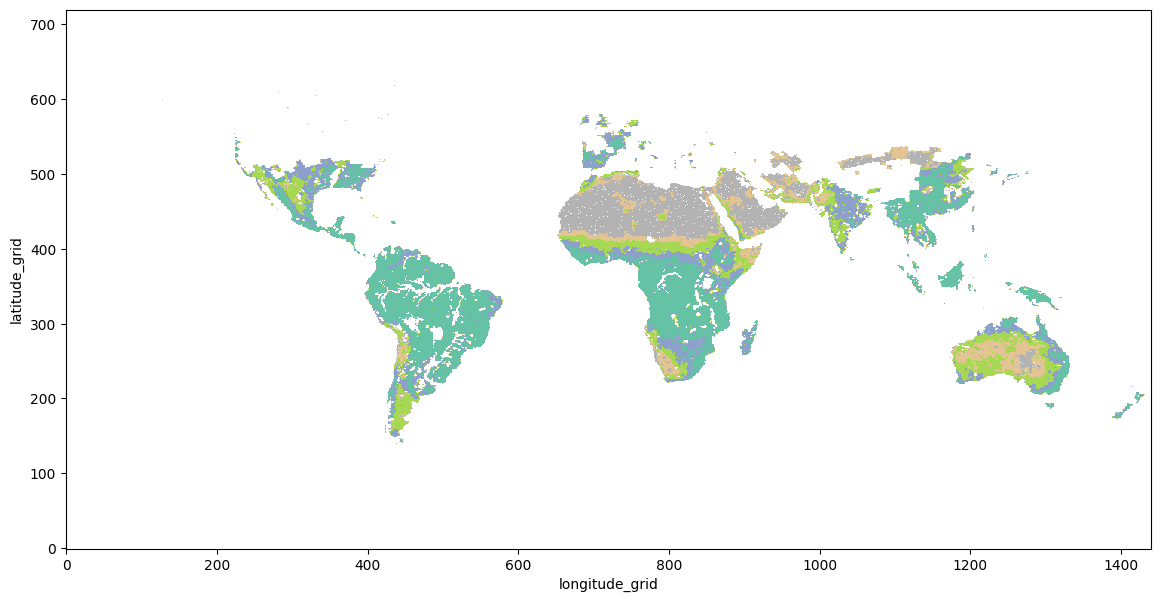

In [67]:
# Select all surface classes between 1 and 5
sclass = sclass.where(sclass <=5)

fig, ax = plt.subplots(1,1,figsize=(14,7))
sclass.plot(cmap = cmap, add_colorbar = False, alpha = 1)


In [71]:
# Load windsat dataset
ws_ds = windsat_datacube(ws_path)
ws_ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [87]:
# Select using the masks and calculate averages for each surface class 

for i, mask in enumerate(masks):
    sub_ds = ws_ds.where(mask == i + 1 )
    mean_lst = sub_ds.surtep_ERA5.mean(dim =["latitude_grid", "longitude_grid","day_number","swath_sector"])
    print(f"Surface Class {i} - Mean surtep_ERA5: {mean_lst.values}")

Surface Class 0 - Mean surtep_ERA5: 293.6818542480469
Surface Class 1 - Mean surtep_ERA5: 289.82958984375
Surface Class 2 - Mean surtep_ERA5: 291.3192443847656
Surface Class 3 - Mean surtep_ERA5: 289.0204772949219
Surface Class 4 - Mean surtep_ERA5: 283.2427978515625


# TODO: 
### Run this with the whole year, or with a more homogenious sample of the whole year